# Imports

In [ ]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
from scipy.io import loadmat

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Mounting Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/ML/3')

Mounted at /content/drive


# Constants

In [ ]:
EPOCHS = 10
PATIENCE = 5
BATCH_SIZE = 32
TEST_SIZE = 0.25
CLASS_NUM = 102
IMAGE_DIM = 250
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_DIM, IMAGE_DIM)
INPUT_SHAPE = IMAGE_SIZE + (IMAGE_CHANNELS,)
PATH = 'jpg'

# Data

In [ ]:
df = pd.DataFrame()
df['x'] = sorted(os.listdir(PATH))
df['y'] = (loadmat('imagelabels.mat')['labels'][0] - 1).astype(str)

## Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['x'], df['y'],
                                                    test_size=TEST_SIZE,
                                                    stratify=df['y'])

train_df = pd.DataFrame()
test_df = pd.DataFrame()

train_df['x'] = x_train
test_df['x'] = x_test

train_df['y'] = y_train
test_df['y'] = y_test

## Image Data Generators

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.5, 1.5],
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

### Rest

In [ ]:
def flow_from_dataframe(datagen, dataframe, shuffle):
  return datagen.flow_from_dataframe(dataframe=dataframe,
                                     directory=PATH,
                                     x_col='x',
                                     y_col='y',
                                     target_size=IMAGE_SIZE,
                                     batch_size=BATCH_SIZE,
                                     class_mode='categorical',
                                     shuffle=shuffle)

In [ ]:
train_generator = flow_from_dataframe(train_datagen, train_df, True)
test_generator = flow_from_dataframe(test_datagen, test_df, False)

Found 6141 validated image filenames belonging to 102 classes.
Found 2048 validated image filenames belonging to 102 classes.


In [ ]:
train_steps = train_generator.samples // train_generator.batch_size
test_steps = test_generator.samples // test_generator.batch_size

# Model

In [ ]:
def transfer_model(application):
  base_model = application(weights='imagenet',
                           include_top=False,
                           input_shape=INPUT_SHAPE)
  model = Sequential([base_model,
                      GlobalAveragePooling2D(),
                      Dense(CLASS_NUM, activation='softmax')])
  return base_model, model

# Training

In [ ]:
def concatenate_histories(*histories):
  ret = {}
  for history in histories:
    for k, v in history.items():
      if k not in ret:
        ret[k] = []
      ret[k] += v
  return ret

In [ ]:
def callbacks(name='model'):
  return [ModelCheckpoint(f'best_{name}.hdf5',
                          monitor=['val_accuracy'],
                          verbose=1,
                          mode='max'),
          EarlyStopping(monitor='val_accuracy',
                        patience=PATIENCE,
                        restore_best_weights=True)]

In [ ]:
def plot_history(history, name='model'):
  fig, axs = plt.subplots(2, figsize=(6.4, 9.6), sharex='all')
  for ax, metric in zip(axs, ['loss', 'accuracy']):
    for subset, prefix in zip(['train', 'test'], ['', 'val_']):
      ax.plot(history[f'{prefix}{metric}'], label=subset)
    ax.set_title(metric)
    ax.legend()
  axs[-1].set_xlabel('epochs')
  plt.savefig(f'{name}.svg')
  plt.show()

In [ ]:
def compile_model(model, lr):
  model.compile(loss="categorical_crossentropy",
                optimizer=Adam(learning_rate=lr),
                metrics=["accuracy"])

In [ ]:
def train_model(model, name='model'):
  return model.fit(train_generator,
                   validation_data=test_generator,
                   steps_per_epoch=train_steps,
                   validation_steps=test_steps,
                   epochs=EPOCHS,
                   callbacks=callbacks(name))

In [ ]:
def save_model(model, i, name='model'):
  model.save(f'{name}_step{i}.hdf5')
  model.load_weights(f'best_{name}.hdf5')

In [ ]:
def train_step(model, lr, i, name='model'):
  compile_model(model, lr)
  history = train_model(model, name)
  save_model(model, i, name)
  return history

In [ ]:
def full_train(application, name='model'):
  multistep_history = {}
  base_model, model = transfer_model(application)

  base_model.trainable = False
  history = train_step(model, 0.001, 1, name)
  multistep_history = concatenate_histories(multistep_history,
                                            history.history)
  
  base_model.trainable = True
  for layer in base_model.layers[:len(base_model.layers) // 2]:
    layer.trainable =  False
  history = train_step(model, 0.0001, 2, name)
  multistep_history = concatenate_histories(multistep_history,
                                            history.history)
  
  base_model.trainable = True
  history = train_step(model, 0.00001, 3, name)
  multistep_history = concatenate_histories(multistep_history,
                                            history.history)
  
  plot_history(multistep_history, name)

191/191 [==============================] - ETA: 0s - loss: 4.3564 - accuracy: 0.0671
Epoch 1: saving model to best_vgg.hdf5
191/191 [==============================] - ETA: 0s - loss: 2.2791 - accuracy: 0.4285
Epoch 1: saving model to best_vgg.hdf5
191/191 [==============================] - ETA: 0s - loss: 0.8187 - accuracy: 0.7771
Epoch 1: saving model to best_vgg.hdf5
191/191 [==============================] - 196s 1s/step - loss: 0.8187 - accuracy: 0.7771 - val_loss: 0.6487 - val_accuracy: 0.8110


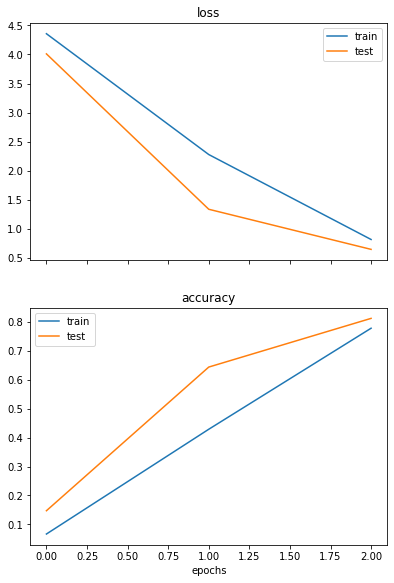

In [ ]:
full_train(VGG19, 'vgg')

In [ ]:
full_train(ResNet152V2, 'resnet')

191/191 [==============================] - ETA: 0s - loss: 2.4876 - accuracy: 0.4567
Epoch 1: saving model to best_resnet.hdf5
191/191 [==============================] - ETA: 0s - loss: 0.7629 - accuracy: 0.8127
Epoch 1: saving model to best_resnet.hdf5
102/191 [===============>..............] - ETA: 1:30 - loss: 0.2699 - accuracy: 0.9384

KeyboardInterrupt: ignored